# Stock Feature Research
首先我們想先選則幾隻股票進行分析，而我們希望這些股票有以下好的特性：
1. 資料量足夠：與此股票相關的文章必須足夠，我們可以用某些機制（ex. 文章包含股票名稱）來算出這個股票的文章數量
2. 股票隨著輿論波動：我們假設文章會因為輿論而有所波動，因此我們希望這些股票的股價也會因為輿論而有所波動，而這點應該要做分析看結果才能知道

我們講用此 notebook 來分析股票性質，進而選取我們關注的股票

### Set up notebook (not important)
change directory to root and import stuff

In [1]:
import os
import random

folder_name = "researchs"
if folder_name in os.getcwd():
    os.chdir(os.path.abspath(os.pardir))
%pwd

'/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中'

## 股票之於文章的特徵分析
首先看一下我們有2607張股票資料，並且看看他們的名字

In [2]:
from datasets.stock_dataset import StockMeta

stock_meta = StockMeta("./organized_data/stock_metadata.csv")
num_stocks = len(stock_meta.stock_names)

random_indices = random.sample(range(num_stocks), 10)
random_stocks = [stock_meta.stock_names[i] for i in random_indices]

# print num stocks and preview some stock name
print(f"number of stocks: {num_stocks}")
print(f"some stock names: {random_stocks}")

number of stocks: 2607
some stock names: ['閎康', '中探針四', '國泰美國道瓊', '永信建', '群益證', '隆大', '中信小資高價30', '嘉澤', '安碁資訊', '興能高一']


再來我們來分析每張股票對應的文章數目，我們使用以下方法判斷是否關係到此股票：
1. 只要文章 title, content, author 包含股票名稱則有關係此股票

對於一張股票我們期望他有以下性質：
1. 每個月都有文章
2. 每個月的文章數量都差不多
那我們就來看看每個月的文章數量吧，首先排序股票用文章數在觀察每個月數量是不是差不多

In [3]:
"""
Loading documents from database and count the number of documents for each stock
"""
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
from tqdm import tqdm
from datasets.docs_dataset import DbDocsDataset
from utils.cacher import Cacher

# load documents from database
db_docs_dataset = DbDocsDataset()
# stock names
stock_names = stock_meta.stock_names

def get_stock_stock_name_to_num_docs(db_docs_dataset, stock_names):

    # a dictionary of stock name to a list of number of documents in each bin
    stock_name_to_num_docs = {}

    # preprocess stock_names into a dictionary for faster lookups
    stock_names = set(stock_names)

    # check if we have cached stock_name_to_num_docs
    cached_stock_name_to_num_docs = Cacher.load("stock_name_to_num_docs")
    if cached_stock_name_to_num_docs is not None:
        print("loaded stock_name_to_num_docs from cache")
        return cached_stock_name_to_num_docs

    # loop through each document, and for each stock, we check whether this document is relevant to this stock, if so, then count it
    for doc in tqdm(db_docs_dataset, desc="filtering docs"):
        doc_text_set = set(doc.title.split() + doc.content.split() + [doc.author])
        relevant_stocks = stock_names.intersection(doc_text_set)

        for stock_name in relevant_stocks:
            if stock_name not in stock_name_to_num_docs:
                stock_name_to_num_docs[stock_name] = {}
            # calculate the bin_name directly
            bin_name = doc.post_time.strftime("%Y-%m")
            if bin_name not in stock_name_to_num_docs[stock_name]:
                stock_name_to_num_docs[stock_name][bin_name] = 0
            stock_name_to_num_docs[stock_name][bin_name] += 1

    # ensure that the bins are sorted and add missing months with a count of 0
    for stock_name, num_docs_in_each_bin in tqdm(stock_name_to_num_docs.items(), desc="converting to num docs every month"):
        sorted_bins = sorted(num_docs_in_each_bin.keys())
        for i in range(len(sorted_bins) - 1):
            bin_name = datetime.strptime(sorted_bins[i], "%Y-%m")
            next_bin_name = datetime.strptime(sorted_bins[i + 1], "%Y-%m")
            if (next_bin_name - bin_name).days > 31:
                # add one month to bin_name
                missing_bin_name = (bin_name + relativedelta(months=1)).strftime("%Y-%m")
                num_docs_in_each_bin[missing_bin_name] = 0

    # cache stock_name_to_num_docs
    Cacher.cache("stock_name_to_num_docs", stock_name_to_num_docs)
    print("store stock_name_to_num_docs to cache")

    return stock_name_to_num_docs



stock_name_to_num_docs = get_stock_stock_name_to_num_docs(db_docs_dataset, stock_names)

loaded stock_name_to_num_docs from cache


1. 若股票有月份沒有文章則我們不使用此股票
2. sort by number of documents
3. plot the number of documents per month for top 20 stocks

After filtering document, we are left with 2175 stocks, since some of the stock never mentioned in any documents

In [4]:
print(f'original number of stocks: {len(stock_names)}')
print(f'number of stocks after filtering: {len(stock_name_to_num_docs)}')

original number of stocks: 2607
number of stocks after filtering: 2175


after delete stocks that have some month without any documents, we are left with 226 stocks

In [5]:
# remove stock that has month without any documents
for stock_name in list(stock_name_to_num_docs.keys()):
    num_docs_in_each_bin = stock_name_to_num_docs[stock_name]
    sorted_bins = sorted(num_docs_in_each_bin.keys())
    for i in range(len(sorted_bins) - 1):
        bin_name = sorted_bins[i]
        next_bin_name = sorted_bins[i + 1]
        if (datetime.strptime(next_bin_name, "%Y-%m") - datetime.strptime(bin_name, "%Y-%m")).days > 31:
            # remove this stock
            del stock_name_to_num_docs[stock_name]
            break

# sort by number of documents
stock_name_to_num_docs = sorted(stock_name_to_num_docs.items(), key=lambda x: sum(x[1].values()), reverse=True)
print(f"number of stocks after removing stocks with month without any documents: {len(stock_name_to_num_docs)}")

number of stocks after removing stocks with month without any documents: 226


當我們來檢視最多文章的股票，我們發現對於多數股票一個月大約落在100左右，然而"友達"看起來特別誇張不太卻確定為什麼，這部分要特別注意，除此之外大部分都有偏數越高，每個月篇數也比別人高的pattern

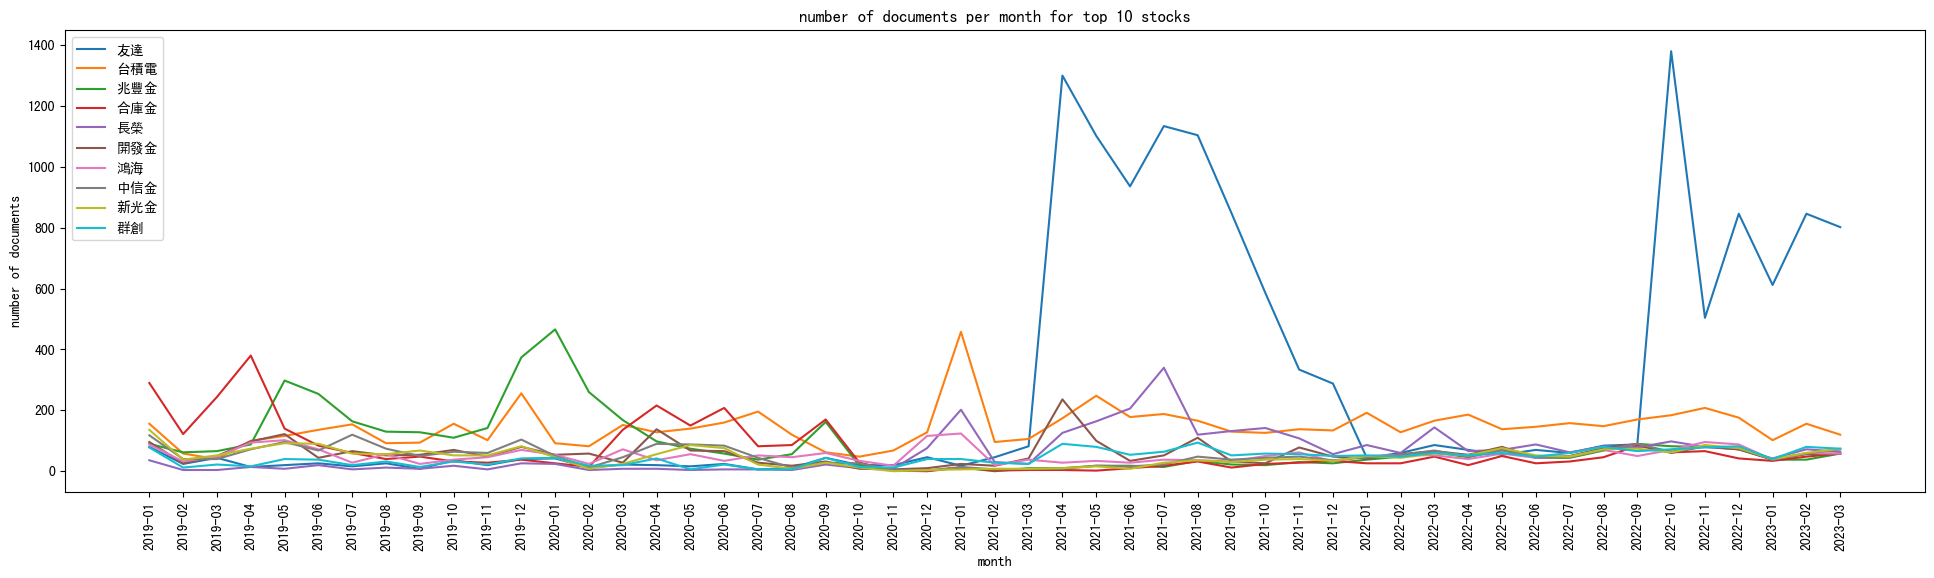

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

topk = 10
# for each stock, plot the number of documents per month, all in one plot
for i in range(topk):
    stock_name = stock_name_to_num_docs[i][0]
    num_docs_in_each_bin = stock_name_to_num_docs[i][1]
    sorted_bins = sorted(num_docs_in_each_bin.keys())
    plt.plot(sorted_bins, [num_docs_in_each_bin[bin_name] for bin_name in sorted_bins], label=stock_name)

plt.legend()
plt.title(f"number of documents per month for top {topk} stocks")
plt.xlabel("month")  # rotate the x-labels by 90 degrees
plt.ylabel("number of documents")
plt.gcf().set_size_inches(24, 6)
# Rotate the x-tick labels by 90 degrees and display them vertically
plt.xticks(rotation=90)
plt.show()


我們可以某些股票std > avg 可能會造成我們訓練時候資料不平均，這點要稍微注意，不過我們這次專題應該不會做太多處理，因此先不處理這個問題

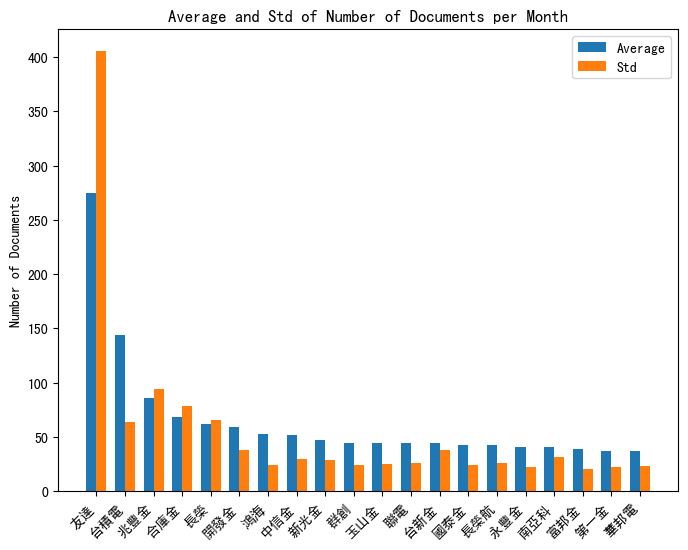

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

topk = 20
avg_values = []
std_values = []
stock_names = []

# for each stock, calculate the average and std values
for i in range(topk):
    stock_name = stock_name_to_num_docs[i][0]
    num_docs_in_each_bin = stock_name_to_num_docs[i][1]
    sorted_bins = sorted(num_docs_in_each_bin.keys())
    avg_value = np.mean([num_docs_in_each_bin[bin_name] for bin_name in sorted_bins])
    std_value = np.std([num_docs_in_each_bin[bin_name] for bin_name in sorted_bins])
    avg_values.append(avg_value)
    std_values.append(std_value)
    stock_names.append(stock_name)

# plot the bar plot of the average and std values
fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(stock_names))
width = 0.35
rects1 = ax.bar(x - width/2, avg_values, width, label='Average')
rects2 = ax.bar(x + width/2, std_values, width, label='Std')

ax.set_ylabel('Number of Documents')
ax.set_title('Average and Std of Number of Documents per Month')
ax.set_xticks(x)
ax.set_xticklabels(stock_names, rotation=45, ha="right")
ax.legend()

plt.show()


## 股票 future return 分析

我們還希望對於股票股票的price趨勢有大概概念，我們future return 定義為與s天候天數比較．

可觀察到s越大則std越大，這是我們希望的，因為大std才表示資料有變異有機會讓模型學習，但同時也要注意s越大我們所用來inference的文章可能就會因太過老舊而沒有用，因此我們應該在後面研究要看s設置多少對於模型最有利。

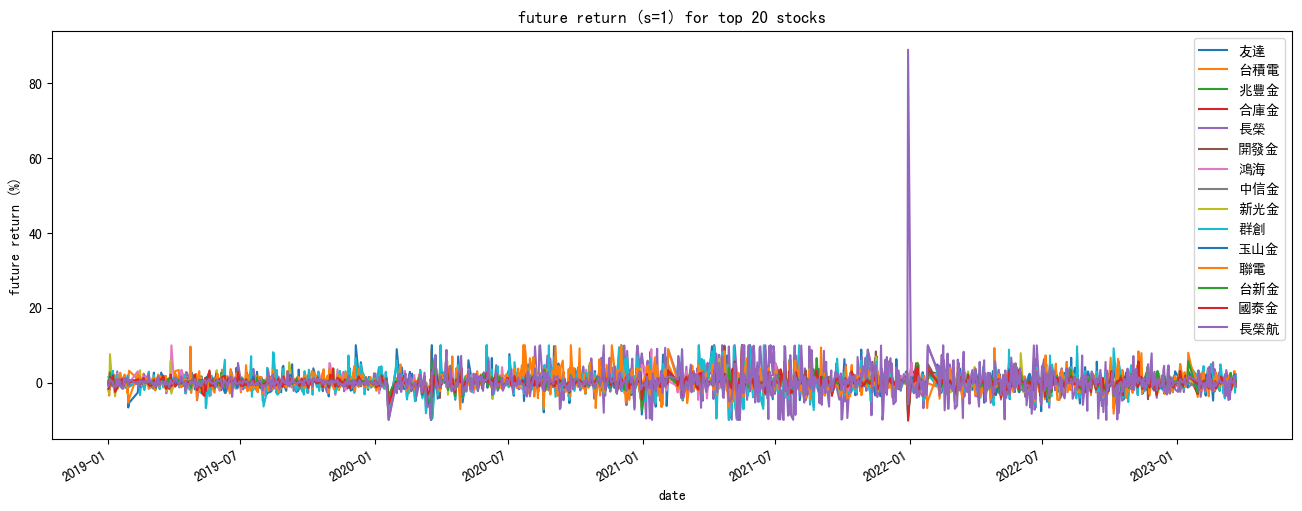

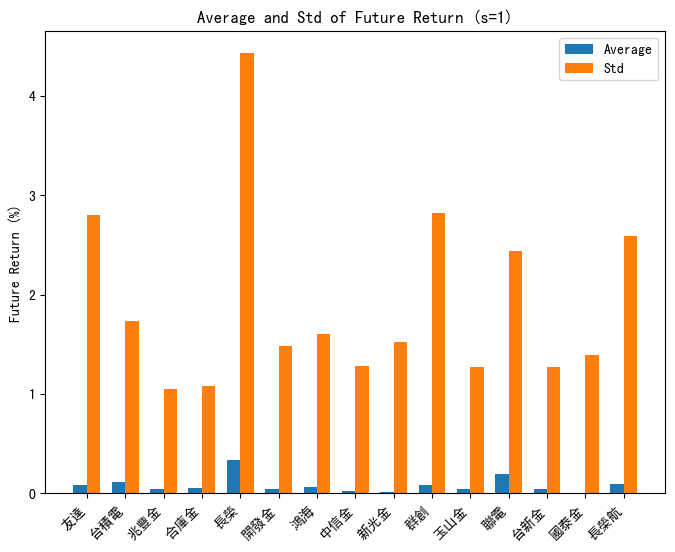

/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


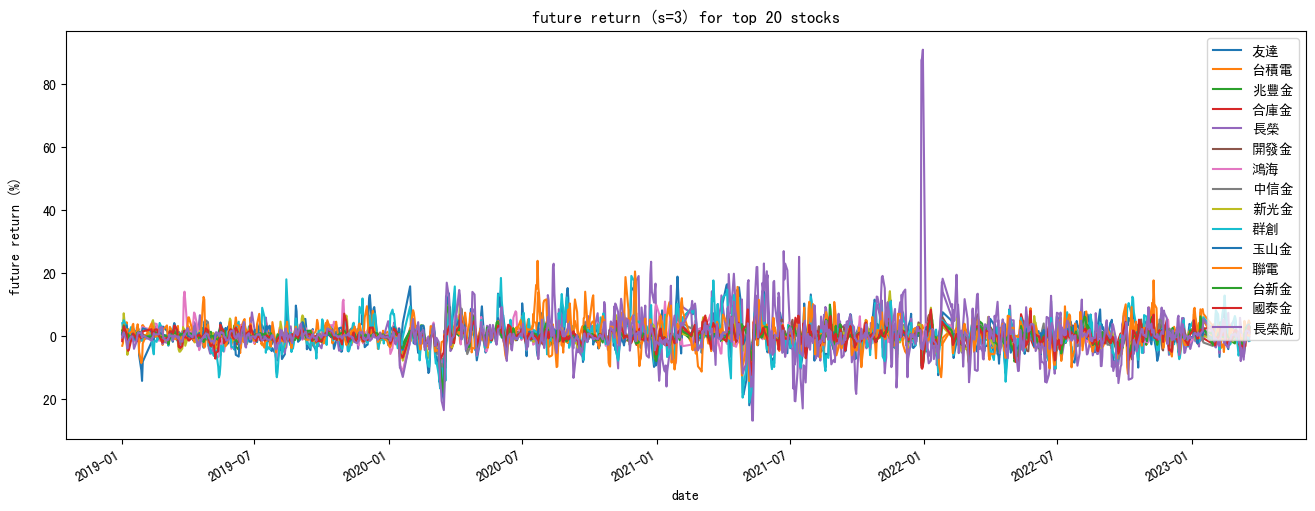

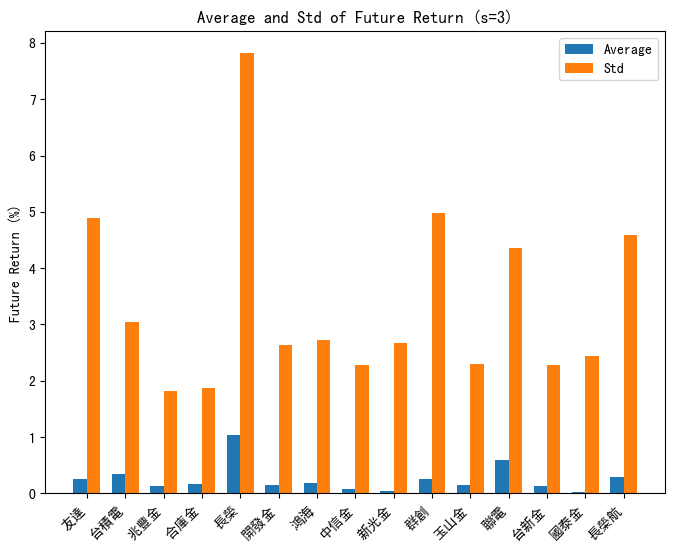

/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


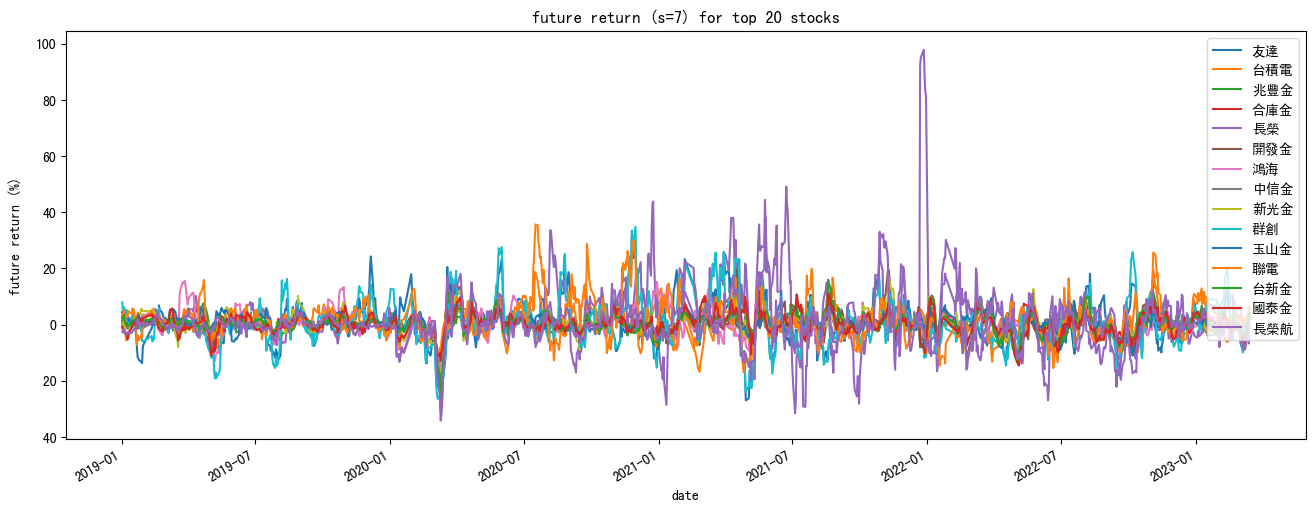

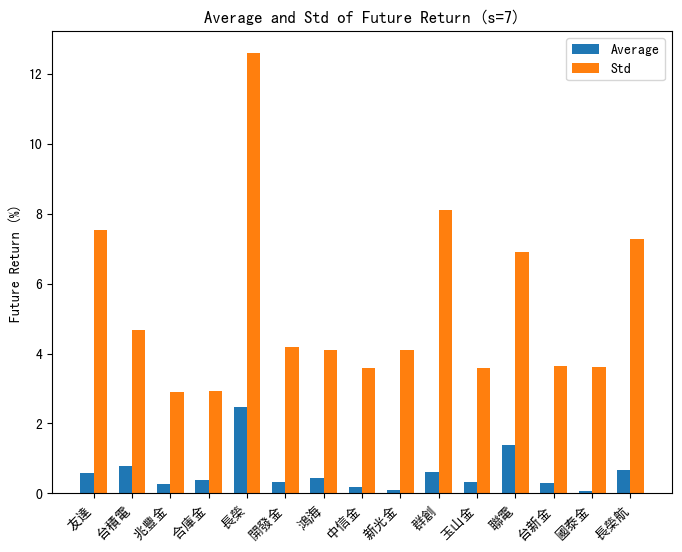

/Users/Ethan/Developer/Projects/College/大四下/數據分析/期中/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


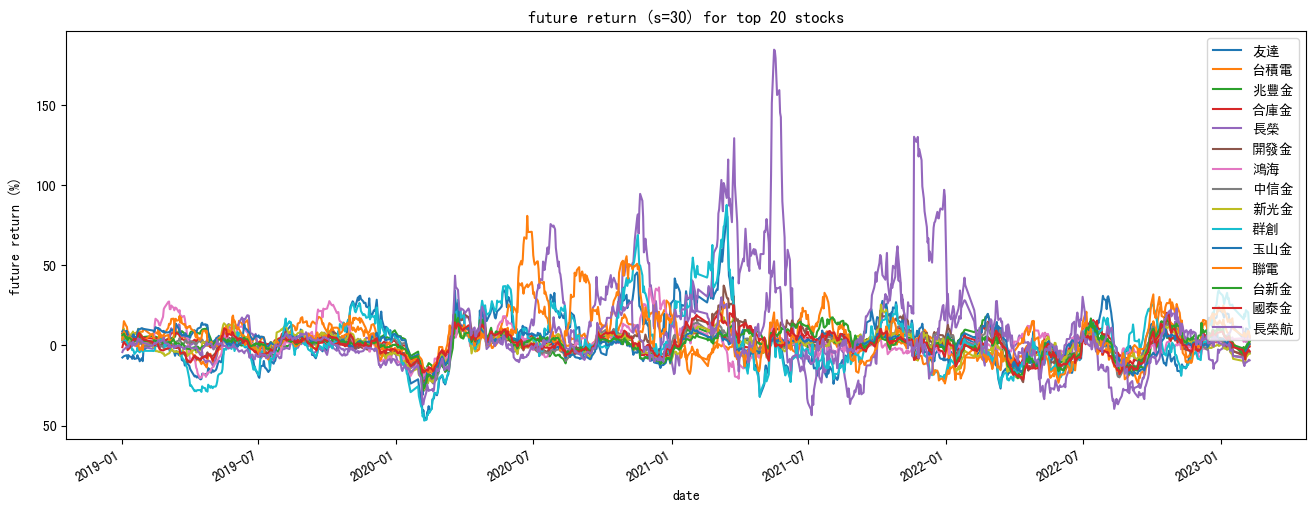

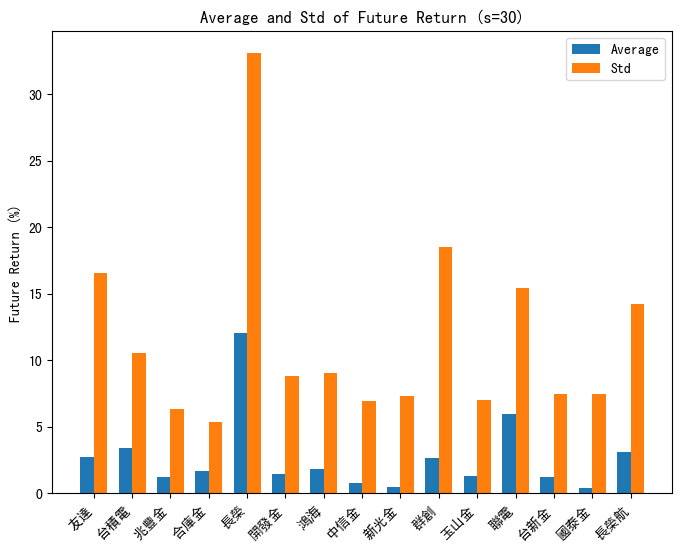

In [52]:
selected_stock_names = [name for name, dates in stock_name_to_num_docs[:15]]
stocks = [stock_meta.get_stock_by_name(name) for name in selected_stock_names]
s = 3

for s in [1, 3, 7, 30]:

    # compute future return for all stock
    for stock in stocks:
        stock.history_df['future_return%'] = stock.history_df['close'].pct_change(s).shift(-s) * 100

    # plot the future return for all stock
    for stock in stocks:
        stock.history_df['future_return%'].plot(label=stock.name)
    plt.legend()
    plt.title(f"future return (s={s}) for top {topk} stocks")
    plt.xlabel("date")  # rotate the x-labels by 90 degrees
    plt.ylabel("future return (%)")
    plt.gcf().set_size_inches(16, 6)
    plt.show()

    # plot the avg and std and some other metrix for all stock
    avg_values = []
    std_values = []
    stock_names = []
    for stock in stocks:
        avg_value = stock.history_df['future_return%'].mean()
        std_value = stock.history_df['future_return%'].std()
        avg_values.append(avg_value)
        std_values.append(std_value)
        stock_names.append(stock.name)

    # plot the bar plot of the average and std values
    fig, ax = plt.subplots(figsize=(8,6))
    x = np.arange(len(stock_names))
    width = 0.35
    rects1 = ax.bar(x - width/2, avg_values, width, label='Average')
    rects2 = ax.bar(x + width/2, std_values, width, label='Std')

    ax.set_ylabel('Future Return (%)')
    ax.set_title(f'Average and Std of Future Return (s={s})')
    ax.set_xticks(x)
    ax.set_xticklabels(stock_names, rotation=45, ha="right")
    ax.legend()

    plt.show()


# 結論
我們有得到兩個重點：
1. 使用股票對於文章，我們找出文章數最多的幾隻股票而因為「友達」的文章變異太大，我們將先不預測此股票（可能有些外在原因我們先假設對於模型會有難度）
2. 使用股票future return，我們發現大部分文章avg, std都差不多但長榮股票在2022-01突然暴漲，這種突發狀況也可能是外在因素，因此我們也先不預測此股票
3. 最後，刪除掉此兩隻股票我們挑以文章數最多作為排序得到以下10張要進行預測的股票
selected_stock_names = ['台積電', '兆豐金', '合庫金', '開發金', '鴻海', '中信金', '新光金', '群創', '玉山金', '聯電']